# Preparation

In [1]:
import sys
sys.path

['D:\\bio\\jupyter_code\\BRCA',
 'D:\\anaconda\\envs\\STAGATE\\python38.zip',
 'D:\\anaconda\\envs\\STAGATE\\DLLs',
 'D:\\anaconda\\envs\\STAGATE\\lib',
 'D:\\anaconda\\envs\\STAGATE',
 '',
 'C:\\Users\\23147\\AppData\\Roaming\\Python\\Python38\\site-packages',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\stagate-1.0.1-py3.8.egg',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\win32',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\win32\\lib',
 'D:\\anaconda\\envs\\STAGATE\\lib\\site-packages\\Pythonwin']

In [2]:
import tensorflow as tf

In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore")

In [4]:
import STAGATE

In [5]:
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = 'D:\\anaconda\envs\STAligner\Lib\R'
os.environ['R_USER'] = 'D:\\anaconda\envs\STAligner\Lib\site-packages\rpy2'

In [6]:
datasets = ["bc1160920F","bc1142243F"]
input_dir = 'G:/dataset/3_BRCA/input/'
output_dir = 'G:/dataset/3_BRCA/output/paste/'
experiment_name = 'BRCA'

# load data

In [7]:
import anndata as ad
adata_list = {}

for dataset in datasets:
    # adata = sc.read_visium(input_dir + dataset)
    # adata.var_names_make_unique()
    # adata.obs_names_make_unique()

    adata = sc.read_h5ad(input_dir + dataset + '.h5ad')
    df = adata.obs[['x','y']].astype('float32')
    adata.obsm['spatial'] = df.values
    
    adata.obs['Ground Truth'] = adata.obs.loc[adata.obs_names, 'Classification'].astype('category')
    
    # adata = adata[~pd.isna(adata.obs['x'])]
    
    # make spot name unique
    adata.obs_names = [x + '_' + dataset for x in adata.obs_names]
    
    adata_list[dataset] = adata.copy()

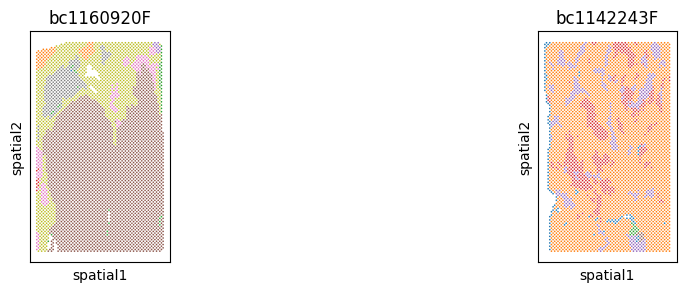

In [8]:
fig, axs = plt.subplots(1, len(datasets), figsize=(12, 3))
it=0
for section_id in datasets:
    if it == len(datasets):
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it],
                      color=["Ground Truth"], title=section_id, show=False, spot_size = 1)
    else:
        sc.pl.spatial(adata_list[section_id], img_key="hires", ax=axs[it], legend_loc=None,
                      color=["Ground Truth"], title=section_id, show=False, spot_size = 1)
    it+=1

------Calculating spatial graph...
The graph contains 56842 edges, 4895 cells.
11.6123 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 55738 edges, 4784 cells.
11.6509 neighbors per cell on average.


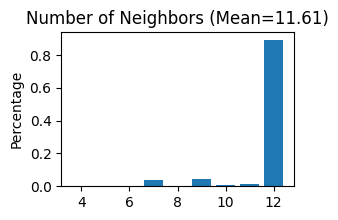

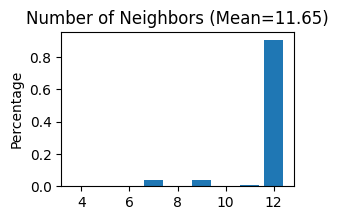

In [9]:
for section_id in datasets:
    STAGATE.Cal_Spatial_Net(adata_list[section_id], rad_cutoff=3)
    STAGATE.Stats_Spatial_Net(adata_list[section_id])

# Conbat the scanpy objects and spatial networks

AnnData object with n_obs × n_vars = 9679 × 28402
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Classification', 'batch', 'x', 'y', 'imagerow', 'imagecol', 'Ground Truth'
    obsm: 'spatial'


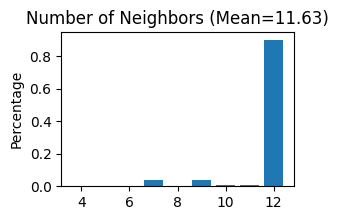

In [10]:
del adata
adata = sc.concat([adata_list[x] for x in datasets], keys=None)
print(adata)
adata.uns['Spatial_Net'] = pd.concat([adata_list[x].uns['Spatial_Net'] for x in datasets])
STAGATE.Stats_Spatial_Net(adata)

In [11]:
print(adata.obsm['spatial'])

[[  1.   5.]
 [  0.   6.]
 [  1.   7.]
 ...
 [ 77. 125.]
 [ 76. 126.]
 [ 77. 127.]]


# Normalization

In [12]:
#Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Running STAGATE

In [13]:
adata

AnnData object with n_obs × n_vars = 9679 × 28402
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Classification', 'batch', 'x', 'y', 'imagerow', 'imagecol', 'Ground Truth'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p'
    obsm: 'spatial'

In [14]:
adata_Vars =  adata[:, adata.var['highly_variable']]
X = pd.DataFrame(adata_Vars.X.toarray()[:, ], index=adata_Vars.obs.index, columns=adata_Vars.var.index)
print(X)
cells = np.array(X.index)
print(cells)

                               AL732372.1  AL645608.2     NOC2L  KLHL17  \
TGTTGGCTGGCGGAAG-1_bc1160920F         0.0         0.0  1.312030     0.0   
GCATCCTCTCCTATTA-1_bc1160920F         0.0         0.0  0.000000     0.0   
GCGAGGGACTGCTAGA-1_bc1160920F         0.0         0.0  1.223042     0.0   
TGGTACCGGCACAGCC-1_bc1160920F         0.0         0.0  0.000000     0.0   
GCGCGTTTAAATCGTA-1_bc1160920F         0.0         0.0  0.000000     0.0   
...                                   ...         ...       ...     ...   
GAACGTTTGTATCCAC-1_bc1142243F         0.0         0.0  0.000000     0.0   
ATTGAATTCCCTGTAG-1_bc1142243F         0.0         0.0  0.000000     0.0   
TACCTCACCAATTGTA-1_bc1142243F         0.0         0.0  0.000000     0.0   
AGTCGAATTAGCGTAA-1_bc1142243F         0.0         0.0  0.000000     0.0   
TTGAAGTGCATCTACA-1_bc1142243F         0.0         0.0  0.885626     0.0   

                               AL645608.7      HES4     ISG15      AGRN  \
TGTTGGCTGGCGGAAG-1_bc116

In [15]:
%%time
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (9679, 3000)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [08:45<00:00,  1.05s/it]


CPU times: total: 1h 15min 11s
Wall time: 8min 46s


In [16]:
print(adata)
print(type(adata.obsm['STAGATE']))

AnnData object with n_obs × n_vars = 9679 × 28402
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Classification', 'batch', 'x', 'y', 'imagerow', 'imagecol', 'Ground Truth'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p'
    obsm: 'spatial', 'STAGATE'
<class 'numpy.ndarray'>


#### save embedding

In [17]:
# save embedding
np.savetxt(output_dir + experiment_name + '_STAGATE.csv', adata.obsm['STAGATE'], delimiter=",")

In [18]:
# import seaborn as sns
# slice_colors = sns.color_palette(n_colors = 6).as_hex()
series = adata.obs['Ground Truth']
series = series.astype("category")

celltype_num = len(series.value_counts().index)
celltypes = series.value_counts().index.tolist()

import seaborn as sns
colors = sns.color_palette(n_colors = celltype_num).as_hex()

num_cluster = celltype_num
print(num_cluster)

11


In [19]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

# louvein
# sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=eval_resolution)

adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=num_cluster)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


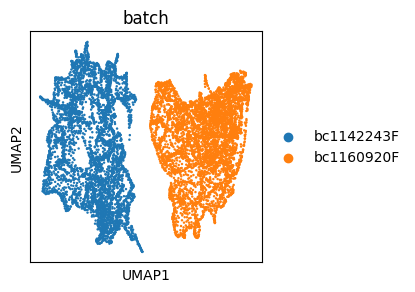

<Figure size 300x300 with 0 Axes>

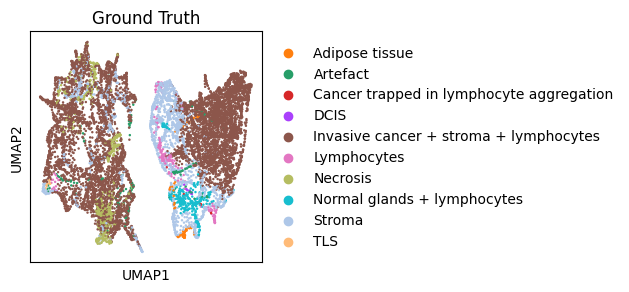

<Figure size 300x300 with 0 Axes>

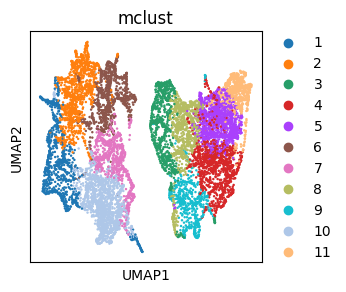

<Figure size 300x300 with 0 Axes>

In [20]:
# adata.obs['batch_name'] = [x.split('_')[-1] for x in adata.obs_names]

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='batch')
plt.savefig(output_dir + experiment_name + '_batch.png', dpi=300)

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Ground Truth')
plt.savefig(output_dir + experiment_name + '_truth.png', dpi=300)

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='mclust')
plt.savefig(output_dir + experiment_name + '_mclust.png', dpi=300)

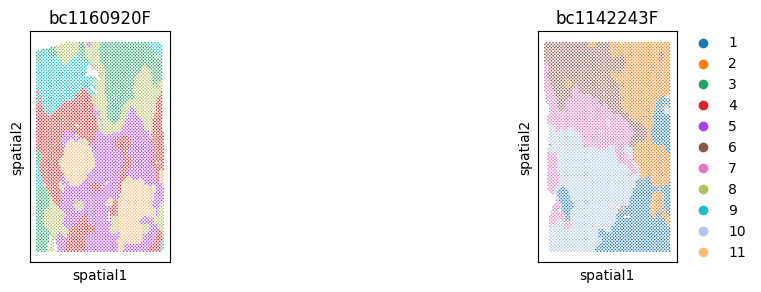

In [21]:
fig, axs = plt.subplots(1, len(datasets), figsize=(12, 3))
it=0
for section_id in datasets:
    adata_list[section_id].obs['STAGATE'] = adata.obs.loc[adata_list[section_id].obs_names, 'mclust']
    if it == len(datasets)-1:
        sc.pl.spatial(adata_list[section_id], img_key=None, ax=axs[it],
                      color=["STAGATE"], title=section_id, show=False, spot_size =1)
    else:
        sc.pl.spatial(adata_list[section_id], img_key=None, ax=axs[it], legend_loc=None,
                      color=["STAGATE"], title=section_id, show=False, spot_size =1)
    it+=1

# Calculate ARI

In [22]:
from sklearn.metrics.cluster import adjusted_rand_score

for section_id in datasets:
    temp_adata = adata[adata.obs['batch']==section_id]
    temp_obs = temp_adata.obs.dropna()
    temp_ARI = adjusted_rand_score(temp_obs['mclust'], temp_obs['Ground Truth'])
    print('ARI of section ID %s: %.3f' %(section_id, temp_ARI))

ARI of section ID bc1160920F: 0.209
ARI of section ID bc1142243F: 0.006


# Visualization

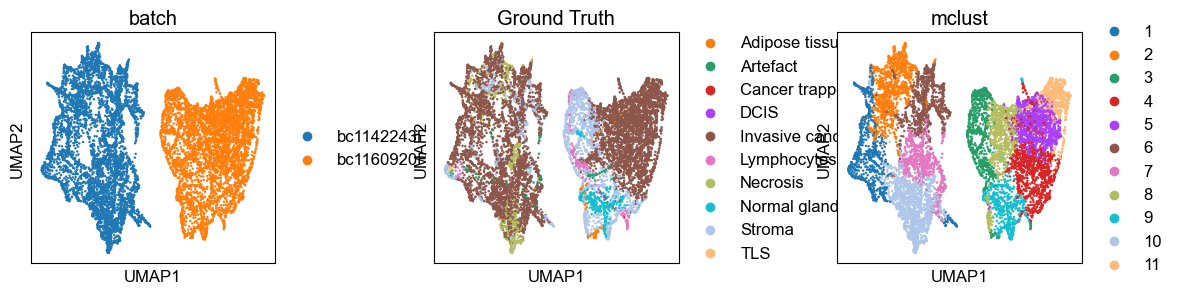

In [23]:
sc.pp.neighbors(adata, use_rep='STAGATE', random_state=666)
sc.tl.umap(adata, random_state=666)

section_color = sns.color_palette(n_colors = len(datasets)).as_hex()
section_color_dict = dict(zip(datasets, section_color))
adata.uns['batch_name_colors'] = [section_color_dict[x] for x in adata.obs.batch.cat.categories]
# adata.obs['mclust'] = pd.Series(ST_utils.match_cluster_labels(adata.obs['Ground Truth'], adata.obs['mclust'].values),
#                                          index=adata.obs.index, dtype='category')

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata, color=['batch', 'Ground Truth', 'mclust'], ncols=3,
           wspace=0.5, show=False)
plt.savefig(output_dir + experiment_name + '_umap.png', dpi=300)

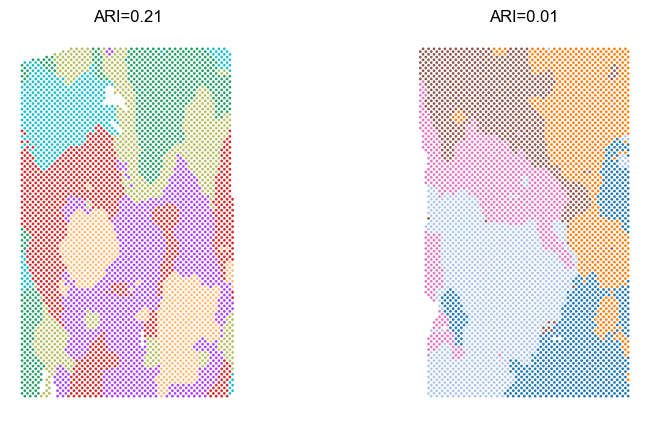

In [24]:
Batch_list = []
for section_id in datasets:
    Batch_list.append(adata[adata.obs['batch'] == section_id])

import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari_score

spot_size = 1
title_size = 12
ARI_list = []
for bb in range(len(datasets)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['mclust']), 2))

fig, ax = plt.subplots(1, len(datasets), figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)

plt.savefig(output_dir + experiment_name + '_ARI.png', dpi=300)
plt.show()

# save

In [25]:
print(type(adata))
print(adata.obsm)
print(adata)

adata.obs = adata.obs.astype('str')

print(adata.isbacked)
adata.filename = output_dir + experiment_name + '.h5ad'
print(adata.isbacked)

<class 'anndata._core.anndata.AnnData'>
AxisArrays with keys: spatial, STAGATE, X_umap
AnnData object with n_obs × n_vars = 9679 × 28402
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Classification', 'batch', 'x', 'y', 'imagerow', 'imagecol', 'Ground Truth', 'mclust'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p', 'neighbors', 'umap', 'batch_colors', 'Ground Truth_colors', 'mclust_colors', 'batch_name_colors'
    obsm: 'spatial', 'STAGATE', 'X_umap'
    obsp: 'distances', 'connectivities'
False
True
